# Overview of the `poligrain` package

In [1]:
import sys

sys.path.append('poligrain/src')

In [2]:
import matplotlib.pyplot as plt
import poligrain as plg

## Get and prepare example data

We download a subset of he OpenMRG dataset which is described in Andersson et al. (2022) here https://doi.org/10.5194/essd-14-5411-2022 and which is available for download at https://doi.org/10.5281/zenodo.6673750

The subset that we use was already processed, in particular the CML data, but with a very basic processing.

In addition, here, we will project the lon-lat coordinates in the fitting UTM zone, so that we can do correct distance calculations.

In [15]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg_5min_2h(data_dir="example_data")

# we still need to rename variables here, until we update the example dataset...
ds_rad = ds_rad.rename({"longitudes": "lon", "latitudes": "lat"})
ds_rad = ds_rad.set_coords(["lon", "lat"])

ds_gauges_municp = ds_gauges_municp.rename({'station_id': 'id'})

File already exists at example_data/openmrg_cml_5min_2h.nc
Not downloading!
File already exists at example_data/openmrg_rad_5min_2h.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_5min_2h.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_5min_2h.nc
Not downloading!


In [16]:
# Project coordinates for rain gauges
ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, "EPSG:25832"
)
ds_gauge_smhi.coords["x"], ds_gauge_smhi.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauge_smhi.lon, ds_gauge_smhi.lat, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:25832"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:25832"
)

# TODO: Reproject radar data

### CML data

In [5]:
ds_cmls

<xarray.Dataset> Size: 122kB
Dimensions:       (cml_id: 359, time: 31)
Coordinates: (12/15)
    sublink_id    <U9 36B ...
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    ...            ...
    quantile      float64 8B ...
  * time          (time) datetime64[ns] 248B 2015-07-25T12:30:00 ... 2015-07-...
    site_0_x      (cml_id) float64 3kB 6.785e+05 6.776e+05 ... 6.792e+05
    site_0_y      (cml_id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x      (cml_id) float64 3kB 6.783e+05 6.77e+05 ... 6.778e+05
    site_1_y      (cml_id) float64 3kB 6.399e+06 6.402e+06 ... 6.401e+06
Data variables:
    R             (time, cml_id) float64 89kB ...
Attributes: (12/14)
    title:                 Transformed and resampled OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se, erlend...
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [11]:
ds_gauges_municp

<xarray.Dataset> Size: 4kB
Dimensions:          (time: 31, id: 10)
Coordinates:
  * id               (id) int64 80B 0 1 2 3 4 5 6 7 8 9
    lon              (id) float64 80B ...
    lat              (id) float64 80B ...
    location         (id) <U16 640B ...
    type             (id) <U14 560B ...
    quantization     (id) float64 80B ...
  * time             (time) datetime64[ns] 248B 2015-07-25T12:30:00 ... 2015-...
Data variables:
    rainfall_amount  (time, id) float64 2kB ...

## Plot data on a map

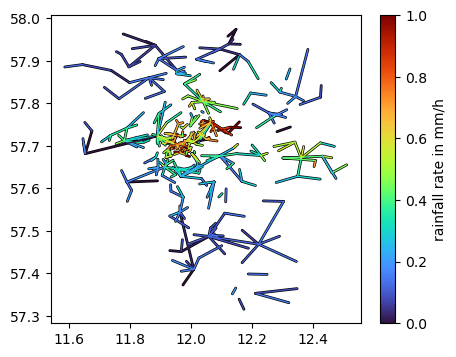

In [12]:
da_R = ds_cmls.R.isel(time=11)

fig, ax = plt.subplots(figsize=(5, 4))
lines = da_R.plg.plot_cmls(pad_width=1, vmin=0, vmax=1, ax=ax, use_lon_lat=True)
plt.colorbar(lines, label="rainfall rate in mm/h");

<Axes: xlabel='longitude [degrees_east]', ylabel='lat'>

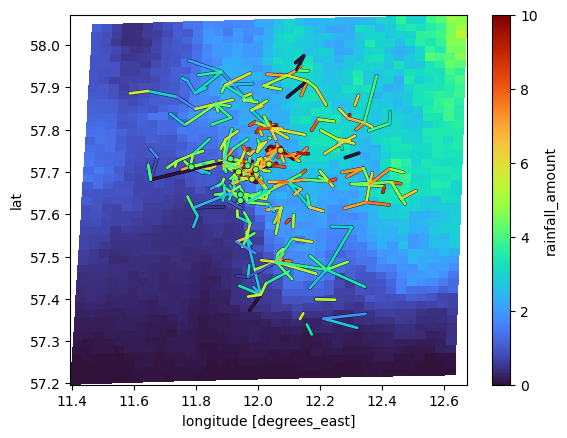

In [13]:
plg.plot_map.plot_plg(
    da_grid=ds_rad.rainfall_amount.sum(dim="time"),
    da_gauges=ds_gauges_municp.rainfall_amount.sum(dim="time"),
    use_lon_lat=True,
    da_cmls=ds_cmls.R.sum(dim="time"),
    vmin=0,
    vmax=10,
)

## Find gauges close to CMLs

In [32]:
max_distance = 5000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cmls, ds_gauges_municp, max_distance=max_distance, n_closest=10
)

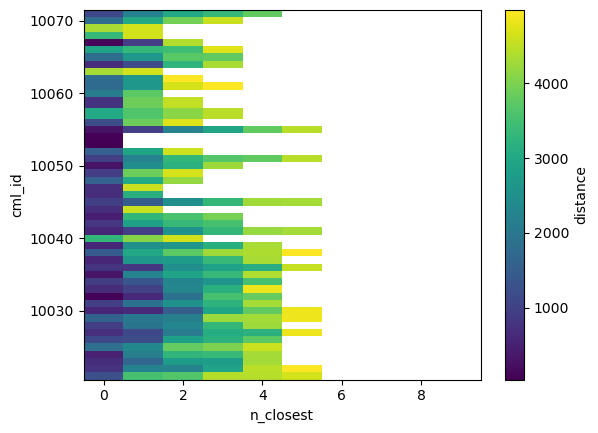

In [37]:
closest_neigbors.isel(cml_id=slice(20, 70)).distance.plot();